In [1]:
import scvi
save_dir = 'data/totalVI'
# adata = scvi.data.pbmcs_10x_cite_seq(save_path=save_dir)
adata = scvi.data.spleen_lymph_cite_seq(save_path=save_dir)
adata.obsm['protein_expression'].shape
adata

/Users/nicholasdjedjos/miniconda3/envs/scvi-env-2/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/Users/nicholasdjedjos/miniconda3/envs/scvi-env-2/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/Users/nicholasdjedjos/miniconda3/envs/scvi-env-2/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/Users/nicholasdjedjos/miniconda3/envs/scvi-env-2/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/Users/nicholasdjedjos/minicon

INFO     Downloading file at data/totalVI/sln_111.h5ad                                                             
Downloading...: 100%|██████████| 66657/66657.0 [00:05<00:00, 11178.63it/s]
INFO     Downloading file at data/totalVI/sln_208.h5ad                                                             
Downloading...: 100%|██████████| 70490/70490.0 [00:06<00:00, 11616.52it/s]


/Users/nicholasdjedjos/miniconda3/envs/scvi-env-2/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/nicholasdjedjos/miniconda3/envs/scvi-env-2/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 30474 × 13553
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch'
    obsm: 'isotypes_htos', 'protein_expression'

In [39]:
import scanpy as sc

In [19]:
# separate by sample, process each one separately
set(adata.obs['batch_indices'])

{0, 1}

In [21]:
set(adata.obs['batch'])

{'SLN111-D1', 'SLN111-D2', 'SLN208-D1', 'SLN208-D2'}

In [25]:
set(adata.obs['cell_types'])

{'Activated CD4 T',
 'B1 B',
 'CD122+ CD8 T',
 'CD4 T',
 'CD8 T',
 'Erythrocytes',
 'GD T',
 'ICOS-high Tregs',
 'Ifit3-high B',
 'Ifit3-high CD4 T',
 'Ifit3-high CD8 T',
 'Ly6-high mono',
 'Ly6-low mono',
 'MZ B',
 'MZ/Marco-high macrophages',
 'Mature B',
 'Migratory DCs',
 'NK',
 'NKT',
 'Neutrophils',
 'Plasma B',
 'Red-pulp macrophages',
 'Transitional B',
 'Tregs',
 'cDC1s',
 'cDC2s',
 'pDCs'}

In [34]:
adata.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 43762899 stored elements and shape (30474, 13553)>

In [48]:
from anndata import AnnData

# adata_qc = AnnData()
for batch in set(list(adata.obs['batch'])):
    print(batch)

SLN111-D1
SLN111-D2
SLN208-D1
SLN208-D2


In [97]:
def preprocessing(batch):  
    adata_name = adata[adata.obs['batch'] == f'{batch}']
    # now need to do normalization
    # mitochondrial genes, "MT-" for human, "Mt-" for mouse
    # this CITE-seq data is mouse data
    adata_name.var["mt"] = adata.var_names.str.startswith("Mt-")
    # ribosomal genes
    adata_name.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    # hemoglobin genes
    adata_name.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

    sc.pp.calculate_qc_metrics(adata_name, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)

    sc.pl.scatter(adata_name, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

    sc.pl.violin(
        adata_name,
        ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
        jitter=0.4,
        multi_panel=True,
    )
    # adata_qc.concatenate(adata_slice)
    sc.pp.filter_cells(adata_name, min_genes=100)
    sc.pp.filter_genes(adata_name, min_cells=3)

    # finding doublets
    # adata.layers["counts"] = adata.X.copy()
    adata_name.layers["counts"] = adata_name.X.copy()
    sc.pp.normalize_total(adata_name)
    sc.pp.log1p(adata_name)


    sc.pp.highly_variable_genes(adata_name, n_top_genes=2000, batch_key="batch")
    sc.pl.highly_variable_genes(adata_name)

    sc.tl.pca(adata_name)

    sc.pl.pca_variance_ratio(adata_name, n_pcs=50, log=True)

#     sc.pl.pca(
#     adata_name,
#     color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
#     dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
#     ncols=2,
#     size=2,
# )
    sc.pp.neighbors(adata_name)
    sc.tl.umap(adata_name)




    return adata_name



/var/folders/gt/1c8d4lks1vgbghz7rr9vnqzm0000gn/T/ipykernel_52535/423240695.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_name.var["mt"] = adata.var_names.str.startswith("Mt-")


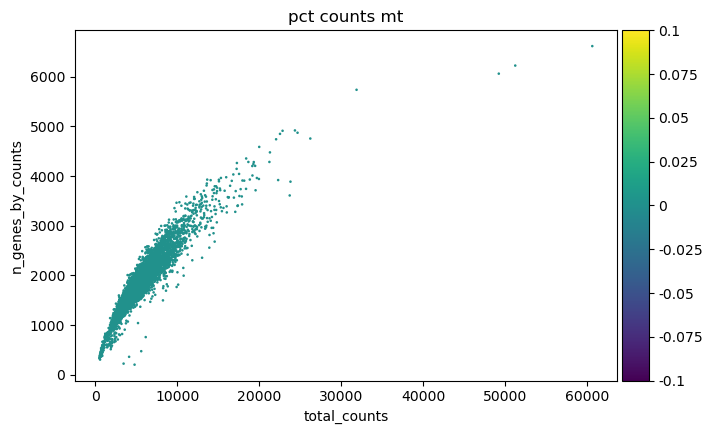

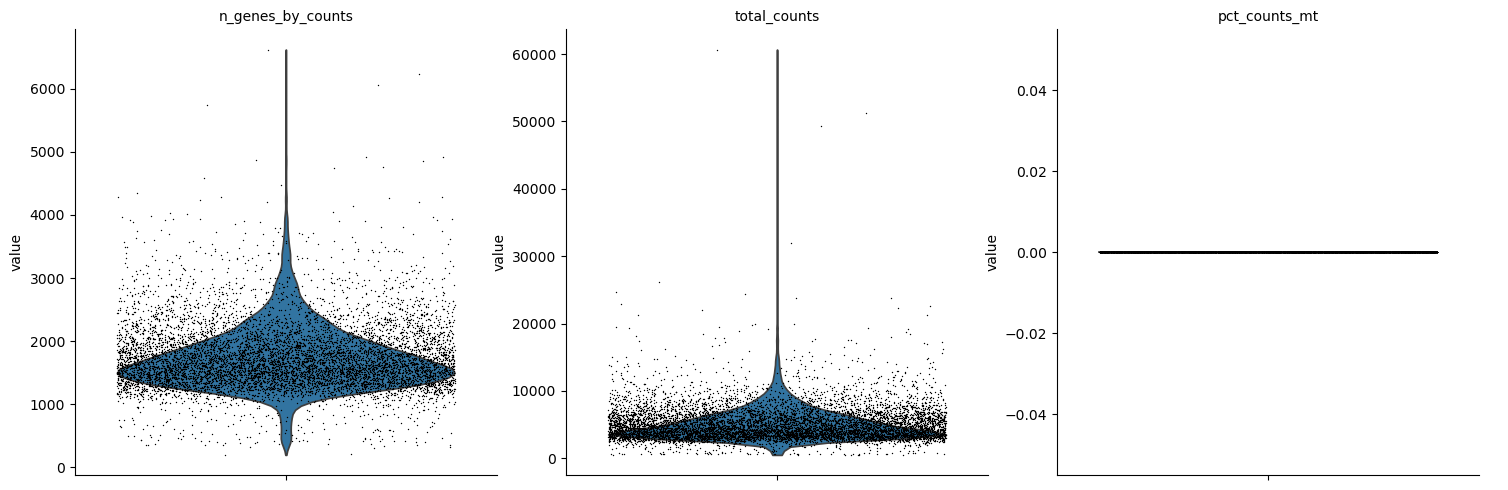

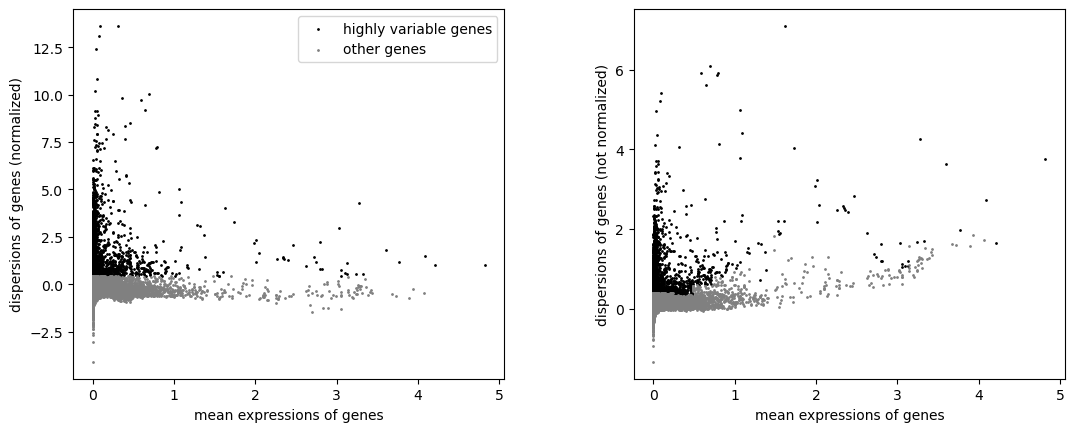

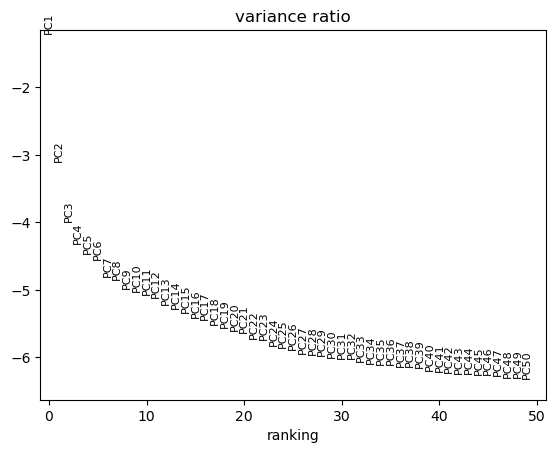

In [98]:
adata_batch_1 = preprocessing('SLN111-D1')

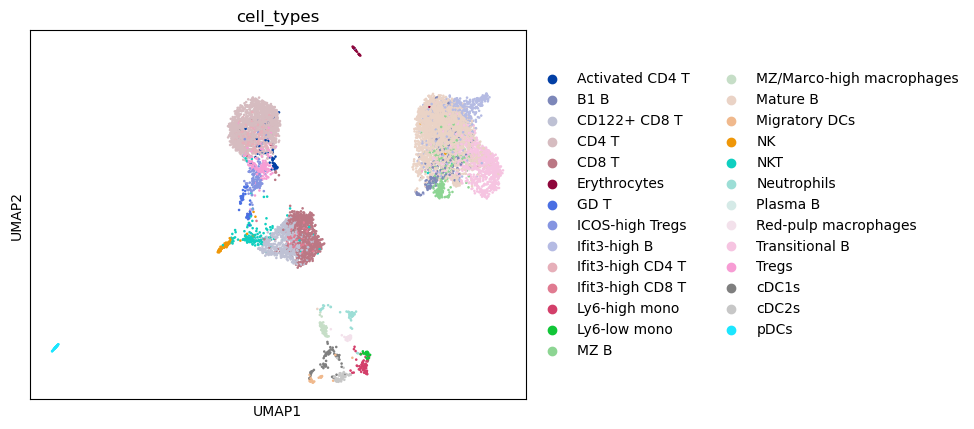

In [99]:
# adata_batch_1
sc.pl.umap(adata_batch_1,color='cell_types')


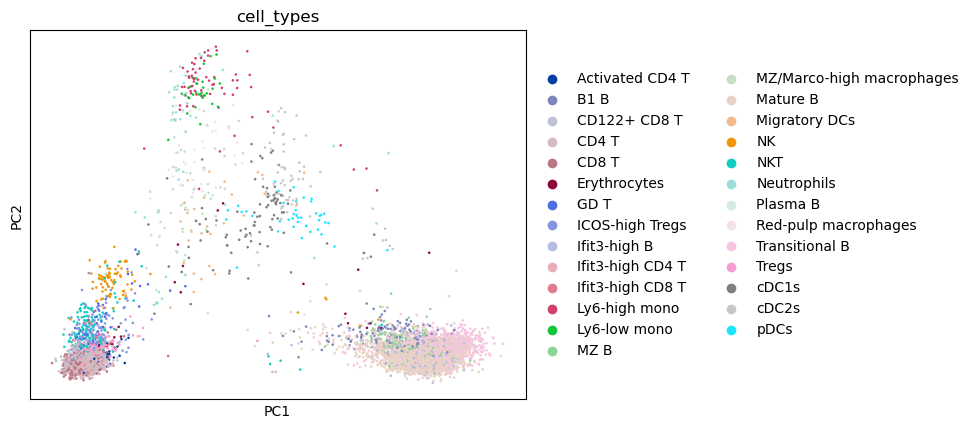

In [100]:
sc.pl.pca(adata_batch_1,color='cell_types')

In [160]:
import anndata as ad
adata_batch_1_protein = ad.AnnData(adata_batch_1.obsm['protein_expression'])

In [158]:
sc.pp.normalize_total(adata_batch_1_protein)
# might need to adjust these parameters for protein, not sure what the filtering should be
sc.pp.filter_cells(adata_batch_1_protein, min_genes=20)
sc.pp.filter_genes(adata_batch_1_protein, min_cells=3)

In [159]:
adata_batch_1_protein

AnnData object with n_obs × n_vars = 4385 × 110
    obs: 'n_genes'
    var: 'n_cells'

In [163]:
adata_batch_1_protein.obs['cell_types'] = adata_batch_1.obs['cell_types']
# adata_batch_1_protein.obs['protein_names'] = adata_batch_1.obsm['protein_expression'].columns

In [161]:
cell_type_mapping = {
    'Activated CD4 T': 'T cells',
    'B1 B': 'B cells',
    'CD122+ CD8 T': 'T cells',
    'CD4 T': 'T cells',
    'CD8 T': 'T cells',
    'Erythrocytes': 'Red blood cells',
    'GD T': 'T cells',
    'ICOS-high Tregs': 'Regulatory T cells',
    'Ifit3-high B': 'B cells',
    'Ifit3-high CD4 T': 'T cells',
    'Ifit3-high CD8 T': 'T cells',
    'Ly6-high mono': 'Monocytes',
    'Ly6-low mono': 'Monocytes',
    'MZ B': 'B cells',
    'MZ/Marco-high macrophages': 'Macrophages',
    'Mature B': 'B cells',
    'Migratory DCs': 'Dendritic cells',
    'NK': 'Natural killer cells',
    'NKT': 'Natural killer T cells',
    'Neutrophils': 'Neutrophils',
    'Plasma B': 'B cells',  # Added missing type
    'Red-pulp macrophages': 'Macrophages',
    'Transitional B': 'B cells',
    'Tregs': 'Regulatory T cells',
    'cDC1s': 'Conventional dendritic cells',
    'cDC2s': 'Conventional dendritic cells',
    'pDCs': 'Plasmacytoid dendritic cells'
}

In [169]:
sc.tl.pca(adata_batch_1_protein)
sc.pp.neighbors(adata_batch_1_protein)
sc.tl.umap(adata_batch_1_protein)


In [174]:
import pandas as pd
adata_batch_1.obs['major_cell_types'] = pd.Categorical( adata_batch_1.obs['cell_types'].map(cell_type_mapping))
adata_batch_1_protein.obs['major_cell_types'] =pd.Categorical(  adata_batch_1_protein.obs['cell_types'].map(cell_type_mapping))

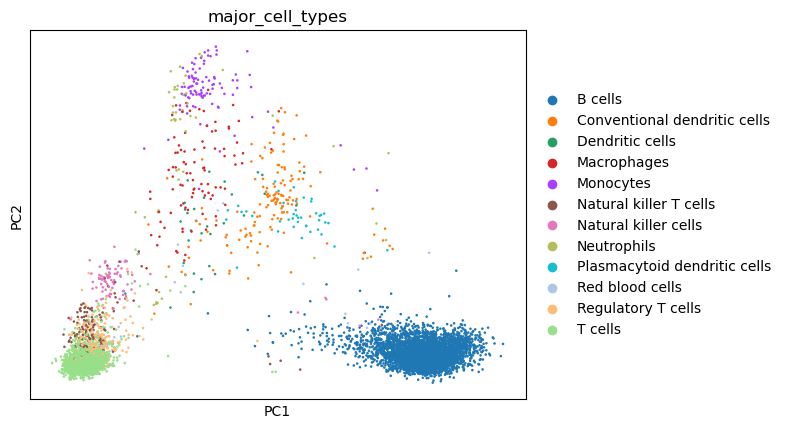

In [166]:
# plotting major cell type, minor cell type
sc.pl.pca(adata_batch_1, color = 'major_cell_types')

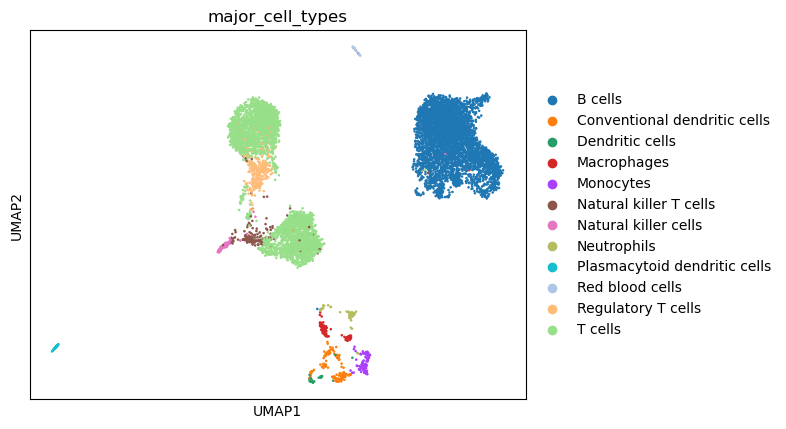

In [172]:
sc.pl.umap(adata_batch_1, color = 'major_cell_types')

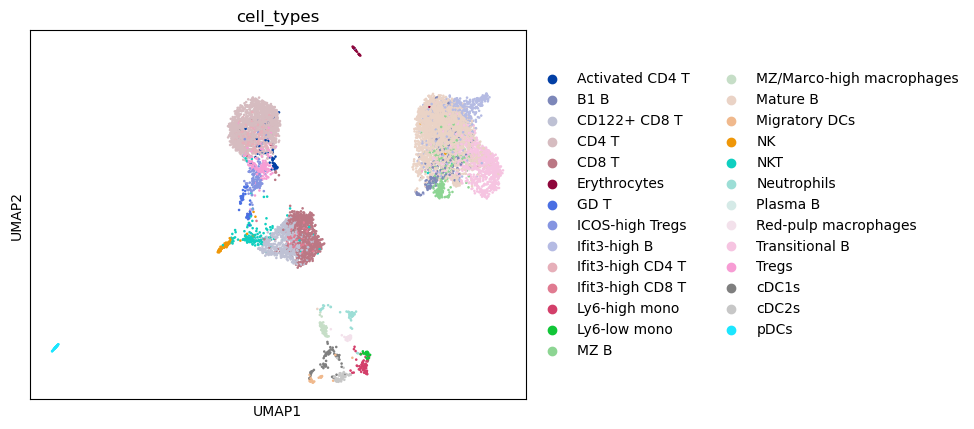

In [179]:
sc.pl.umap(adata_batch_1, color='cell_types')

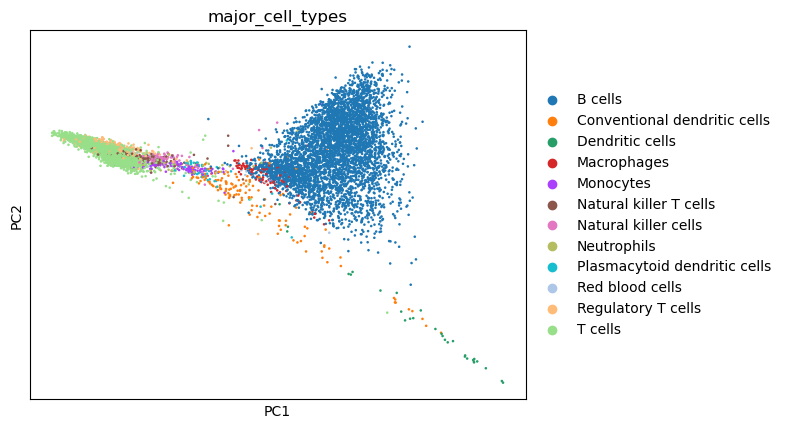

In [176]:
sc.pl.pca(adata_batch_1_protein, color='major_cell_types')

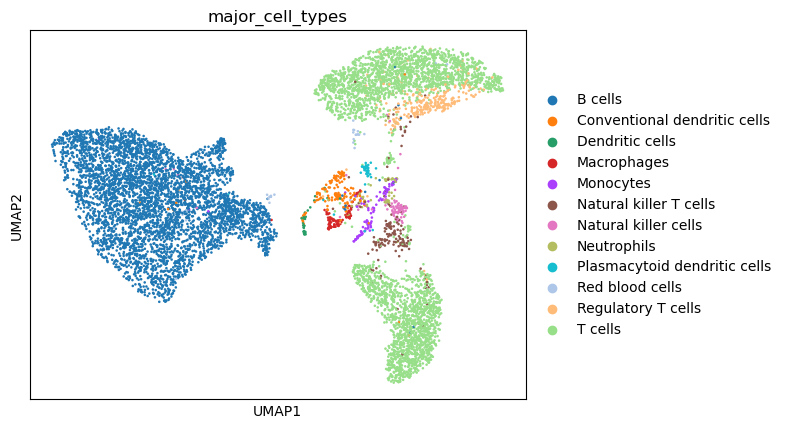

In [177]:
sc.pl.umap(adata_batch_1_protein, color='major_cell_types')

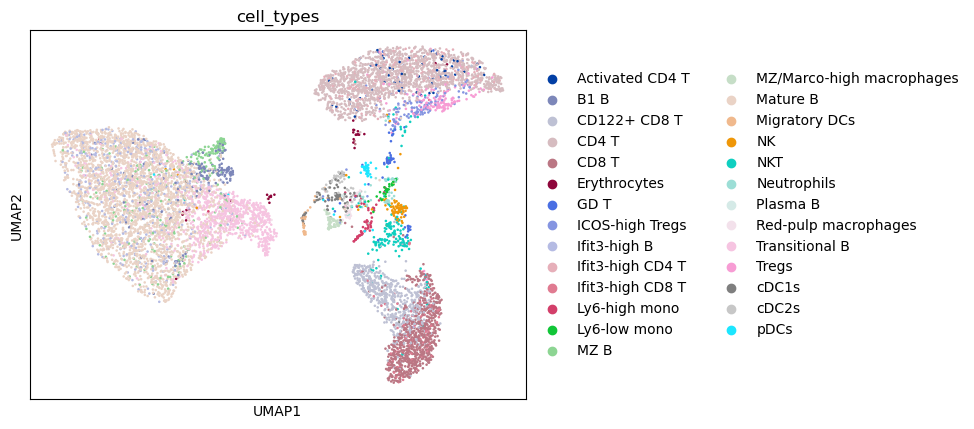

In [178]:
sc.pl.umap(adata_batch_1_protein, color = 'cell_types')

In [180]:
from sklearn.metrics import silhouette_score

In [ ]:
# need to calculate silhouette score

silhouette_score_per_cell_type_original= {}
silhouette_score_per_cell_type_latent = {}
silhouette_score_per_cell_type= {}
cell_type_indexes = adata_batch_1.obs['major_cell_types'] == 'B cells'
cell_type_data = adata_batch_1[cell_type_indexes].X
minor_cell_type_lables =  adata_batch_1[cell_type_indexes].obs['cell_types']
# curr_latent = adata_batch_1.obsm[SCVI_LATENT_KEY][cell_type_indexes]

# silhouette_score_per_cell_type['original_B cells'] = silhouette_score(cell_type_data, minor_cell_type_lables)
# silhouette_score_per_cell_type['Ours B cells'] = silhouette_score(curr_latent, minor_cell_type_lables)

In [183]:
silhouette_score(adata_batch_1.X, adata_batch_1.obs['major_cell_types'])

0.026692087

In [185]:
silhouette_score(adata_batch_1.X, adata_batch_1.obs['cell_types'])

-0.04765531

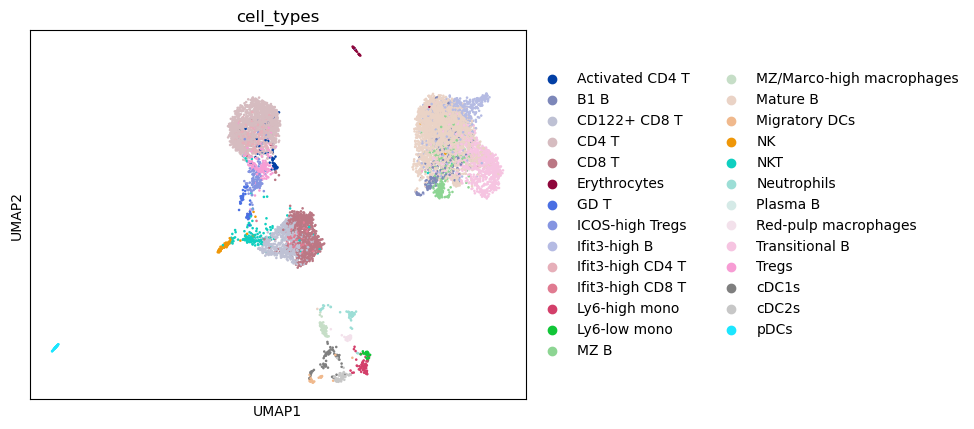

In [187]:
sc.pl.umap(adata_batch_1, color='cell_types')

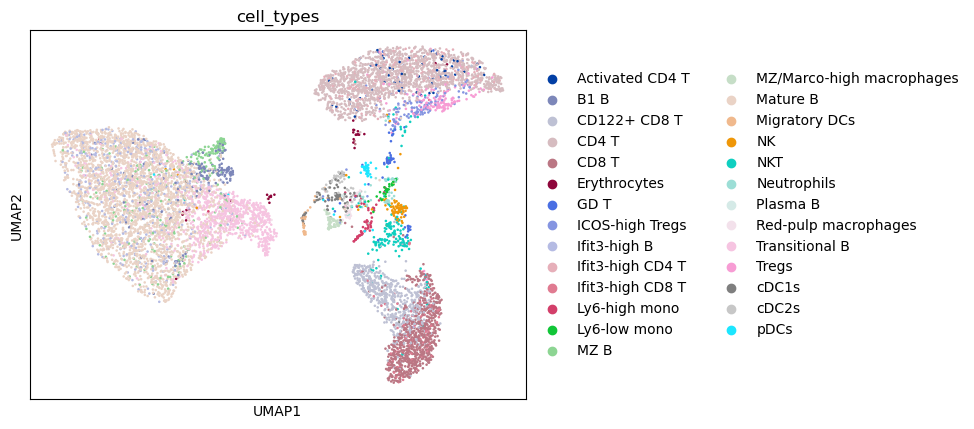

In [188]:
sc.pl.umap(adata_batch_1_protein, color='cell_types')

In [184]:
silhouette_score(adata_batch_1_protein.X, adata_batch_1.obs['major_cell_types'])

0.18961099

In [186]:
silhouette_score(adata_batch_1_protein.X, adata_batch_1.obs['cell_types'])

0.0064851483

In [ ]:
# doing silhouette score with highly variable genes

In [195]:
# Filter the data to include only highly variable genes
highly_variable_mask = adata_batch_1.var['highly_variable']

# Create a new AnnData object with highly variable genes
adata_batch_1hvg = adata_batch_1[:, highly_variable_mask].copy()


In [198]:
adata_batch_1hvg

AnnData object with n_obs × n_vars = 8736 × 2000
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'major_cell_types'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'pca', 'neighbors', 'umap', 'log1p', 'hvg', 'cell_types_colors', 'major_cell_types_colors'
    obsm: 'isotypes_htos', 'protein_expressi

In [199]:
silhouette_score(adata_batch_1hvg.X, adata_batch_1hvg.obs['cell_types'])

-0.0026091773

In [200]:
silhouette_score(adata_batch_1hvg.X, adata_batch_1hvg.obs['major_cell_types'])

0.17895663

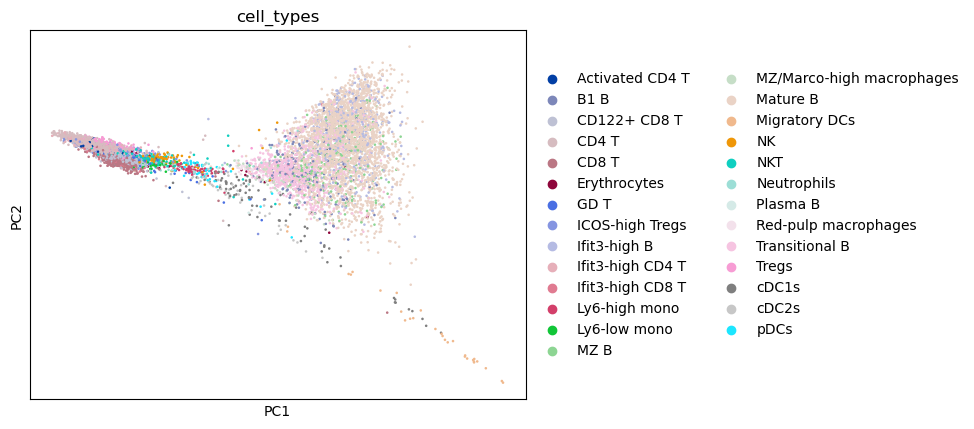

In [145]:
sc.pl.pca(adata_batch_1_protein, color = 'cell_types')

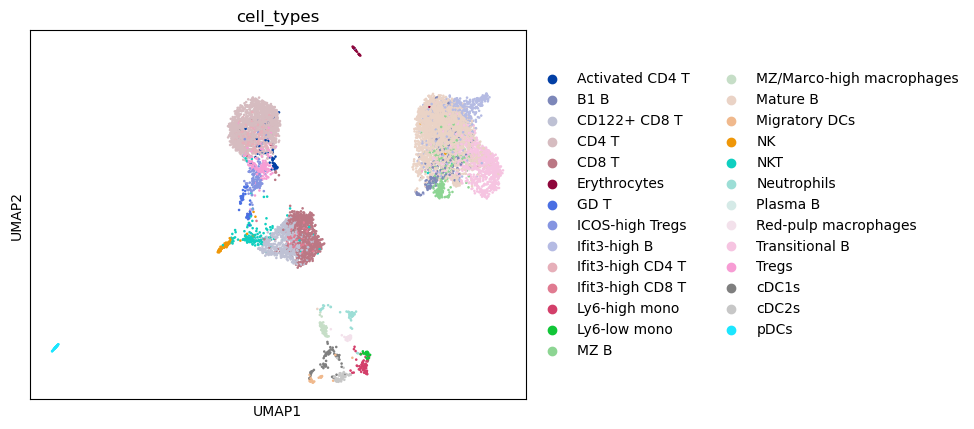

In [148]:
sc.pl.umap(adata_batch_1,color='cell_types')

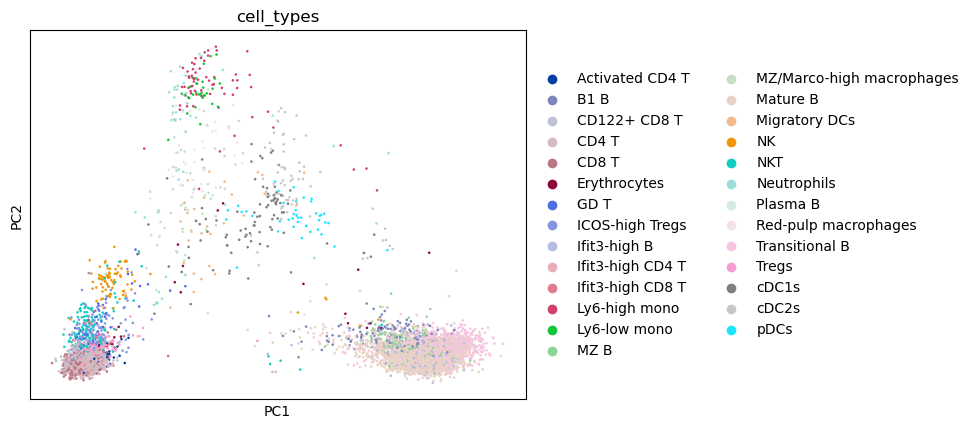

In [149]:
sc.pl.pca(adata_batch_1,color='cell_types')

In [141]:
adata_batch_1_protein

AnnData object with n_obs × n_vars = 8736 × 110
    obs: 'cell_types'

In [130]:
import numpy as np
def clr_normalization(data):
    """Apply centered log-ratio normalization."""
    data = np.array(data)
    data_sum = np.sum(data, axis=1, keepdims=True)
    data_clr = np.log1p(data / data_sum)
    return data_clr

# Apply CLR normalization to protein data


In [132]:
# adata_batch_1_protein.obsm["protein_clr"] = clr_normalization(adata_batch_1.obsm['protein_expression'])


In [122]:
# adata_batch_1_protein.obsm["protein_clr"]

array([[0.03240073, 0.00277907, 0.00277907, ..., 0.00185357, 0.00046371,
        0.03060298],
       [0.00399772, 0.00028608, 0.00057208, ..., 0.00057208, 0.00114384,
        0.00570615],
       [0.05505978, 0.00157109, 0.00470589, ..., 0.00078585, 0.00235571,
        0.00470589],
       ...,
       [0.02466493, 0.00113443, 0.00603548, ..., 0.00075643, 0.002645  ,
        0.00866459],
       [0.01246421, 0.00529229, 0.00192771, ..., 0.00048228, 0.00096432,
        0.00673079],
       [0.0116892 , 0.00117509, 0.00058772, ..., 0.00058772, 0.00117509,
        0.00644596]], dtype=float32)

In [123]:
sc.tl.pca(adata_batch_1_protein.obsm["protein_clr"])

array([[-8.4983081e-02, -2.5897417e-02, -1.2229070e-02, ...,
        -2.2237701e-03, -2.2380280e-03,  8.2860456e-04],
       [-1.3150051e-01, -7.9966716e-02,  5.1247060e-02, ...,
        -1.0148217e-03,  2.0015308e-04, -6.9366640e-04],
       [ 2.6848292e-02, -6.1956484e-02, -4.6684664e-02, ...,
        -2.0050355e-03, -3.1697346e-04, -8.7561616e-04],
       ...,
       [ 8.4884852e-02, -2.6218712e-02, -3.3958439e-02, ...,
        -5.6613312e-04, -3.2126147e-04,  6.4881104e-05],
       [-1.5300952e-01,  3.5494264e-02, -4.7310079e-03, ...,
         1.6345245e-04, -2.5745007e-04, -1.4728685e-03],
       [-1.5358397e-01,  6.9014527e-02, -2.3763821e-02, ...,
        -8.1724743e-04,  1.5310905e-04,  4.9848179e-05]], dtype=float32)

In [124]:
sc.pl.pca(adata_batch_1_protein.obsm["protein_clr"])

AttributeError: 'numpy.ndarray' object has no attribute '_sanitize'

In [110]:
sc.pp.normalize_total(adata_batch_1_protein.obsm['protein_expression'])
sc.pp.log1p(adata_batch_1_protein.obsm['protein_expression'])


AttributeError: 'DataFrame' object has no attribute 'is_view'

In [85]:
adata_batch_2 = preprocessing('SLN111-D2')

AnnData object with n_obs × n_vars = 8736 × 13548
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    obsm: 'isotypes_htos', 'protein_expression'
    layers: 'counts'

/var/folders/gt/1c8d4lks1vgbghz7rr9vnqzm0000gn/T/ipykernel_52535/4145732023.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_name.var["mt"] = adata.var_names.str.startswith("Mt-")


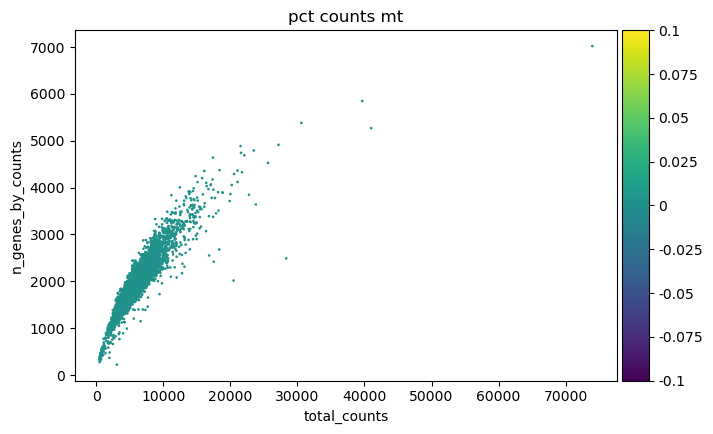

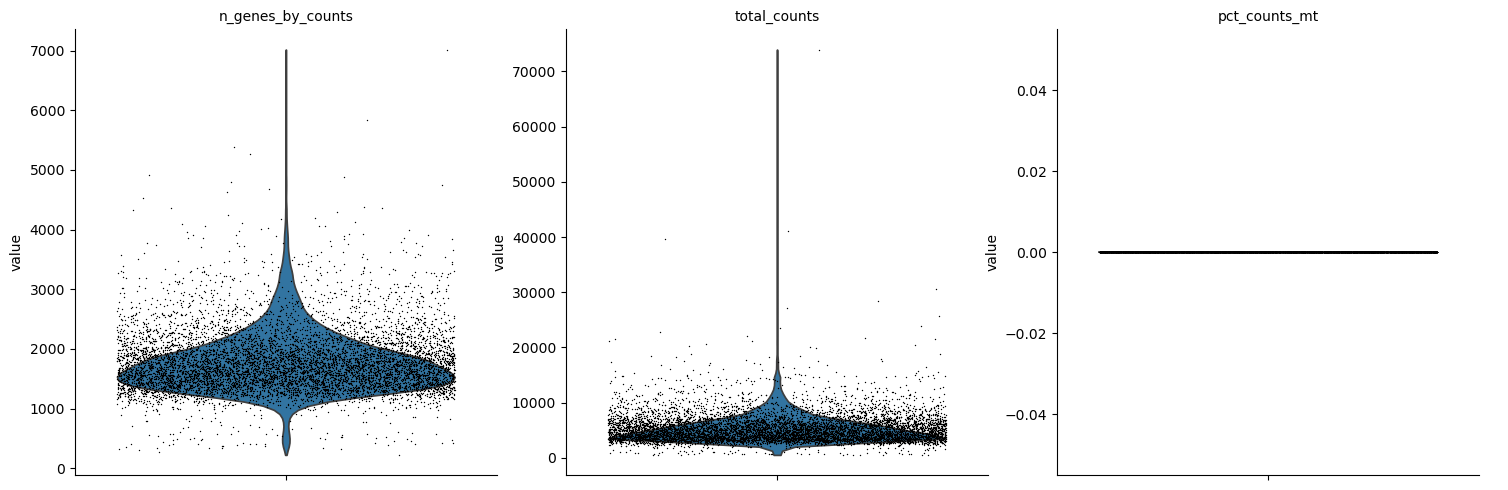

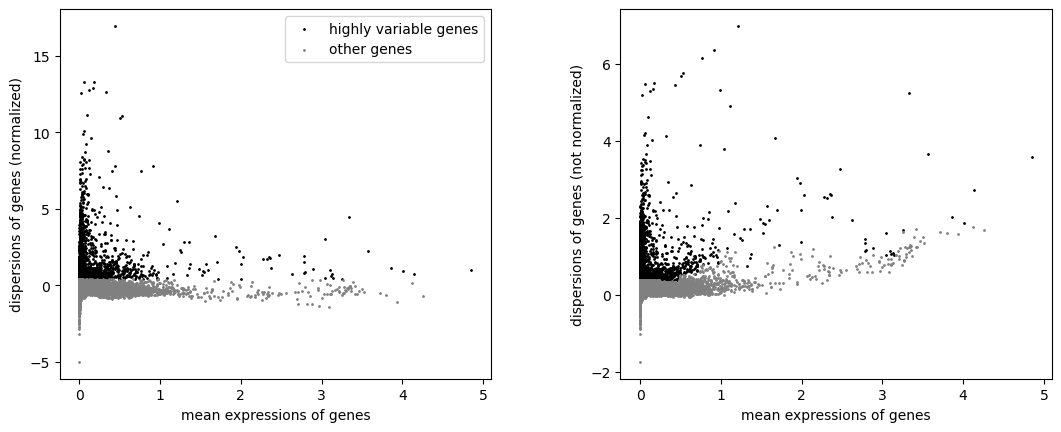

In [86]:
adata_batch_3 = preprocessing('SLN208-D1')

/var/folders/gt/1c8d4lks1vgbghz7rr9vnqzm0000gn/T/ipykernel_52535/4145732023.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_name.var["mt"] = adata.var_names.str.startswith("Mt-")


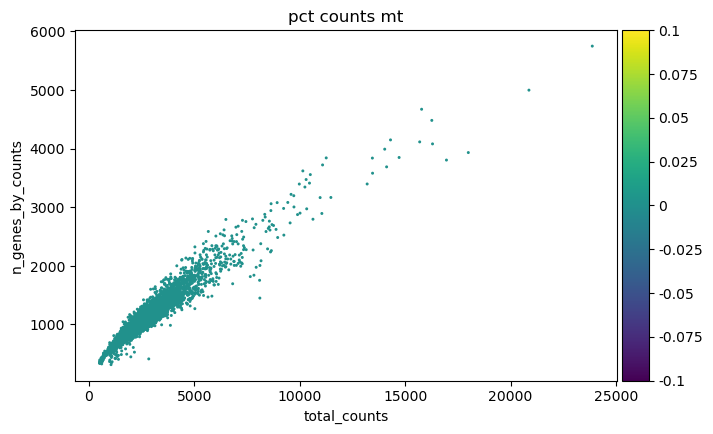

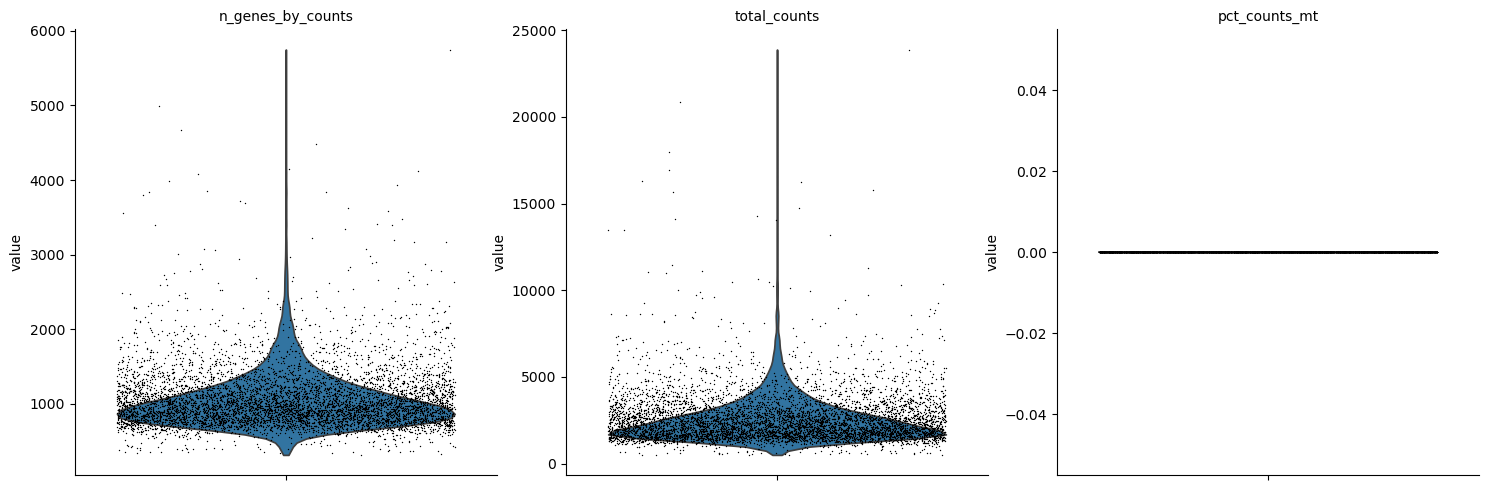

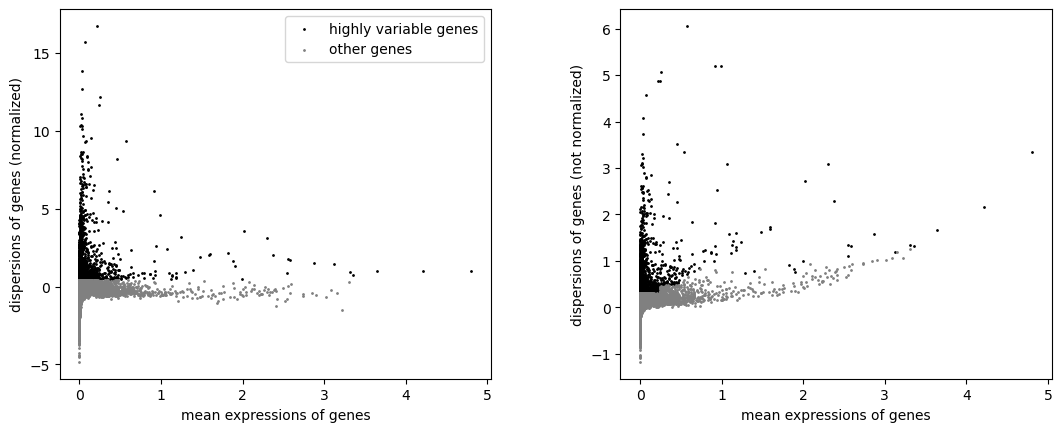

In [87]:
adata_batch_4 = preprocessing('SLN208-D2')

/var/folders/gt/1c8d4lks1vgbghz7rr9vnqzm0000gn/T/ipykernel_52535/2634957482.py:5: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_111_D1.var["mt"] = adata.var_names.str.startswith("Mt-")


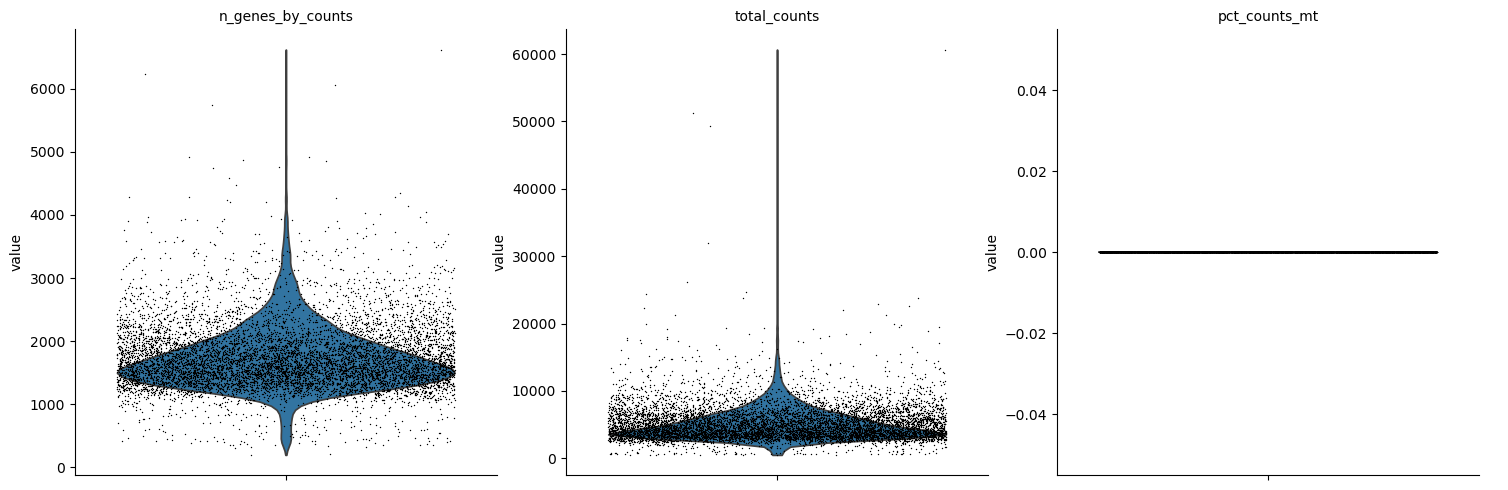

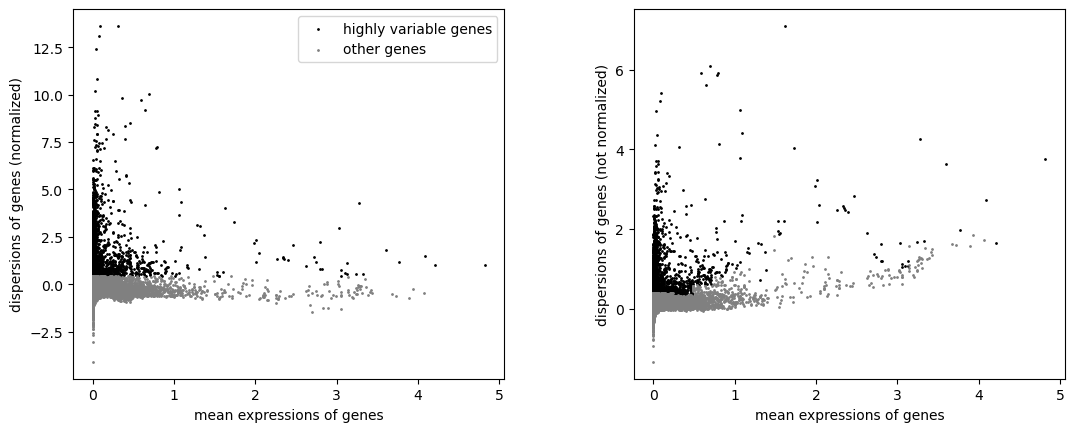

In [77]:
def preprocessing(adata_name, batch):  
    adata_111_D1 = adata[adata.obs['batch'] == f'SLN111-D1']
    # now need to do normalization
    # mitochondrial genes, "MT-" for human, "Mt-" for mouse
    # this CITE-seq data is mouse data
    adata_111_D1.var["mt"] = adata.var_names.str.startswith("Mt-")
    # ribosomal genes
    adata_111_D1.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    # hemoglobin genes
    adata_111_D1.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

    sc.pp.calculate_qc_metrics(adata_111_D1, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)

    sc.pl.scatter(adata_111_D1, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

    sc.pl.violin(
        adata_111_D1,
        ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
        jitter=0.4,
        multi_panel=True,
    )
    # adata_qc.concatenate(adata_slice)
    sc.pp.filter_cells(adata_111_D1, min_genes=100)
    sc.pp.filter_genes(adata_111_D1, min_cells=3)

    # finding doublets
    # adata.layers["counts"] = adata.X.copy()
    adata_111_D1.layers["counts"] = adata_111_D1.X.copy()
    sc.pp.normalize_total(adata_111_D1)
    sc.pp.log1p(adata_111_D1)


    sc.pp.highly_variable_genes(adata_111_D1, n_top_genes=2000, batch_key="batch")
    sc.pl.highly_variable_genes(adata_111_D1)



/var/folders/gt/1c8d4lks1vgbghz7rr9vnqzm0000gn/T/ipykernel_52535/2915699651.py:5: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_111_D2.var["mt"] = adata.var_names.str.startswith("Mt-")


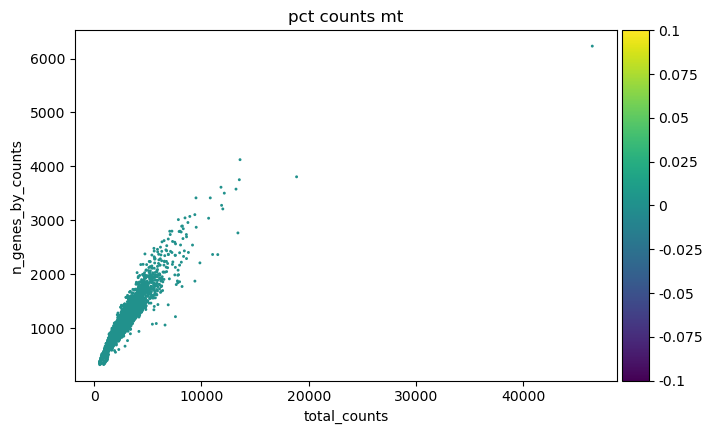

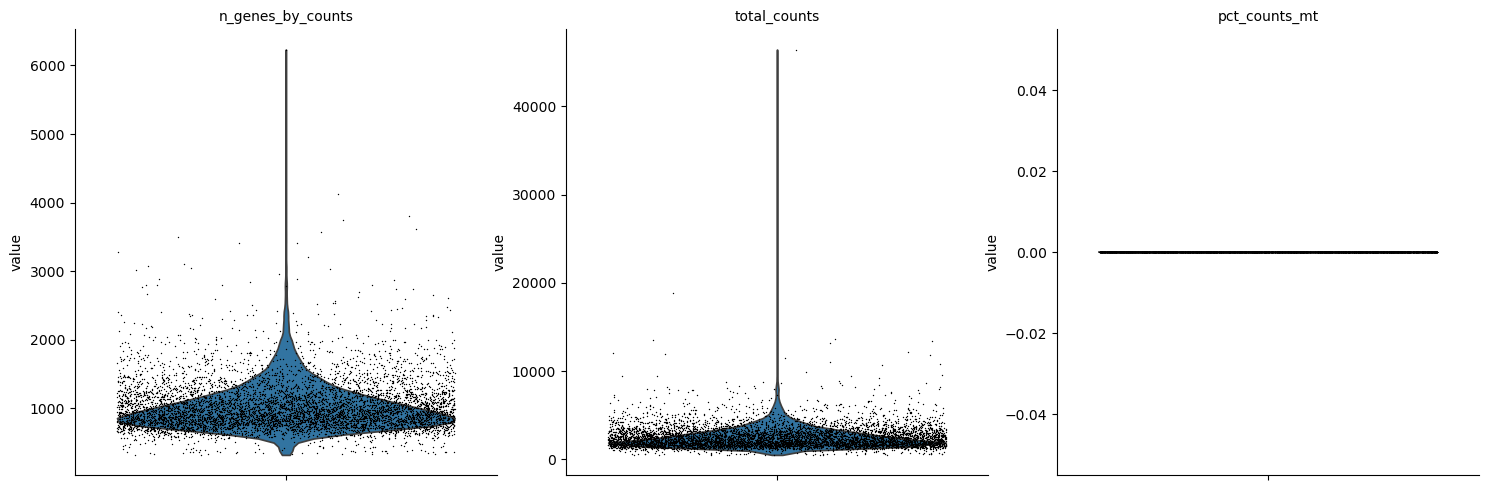

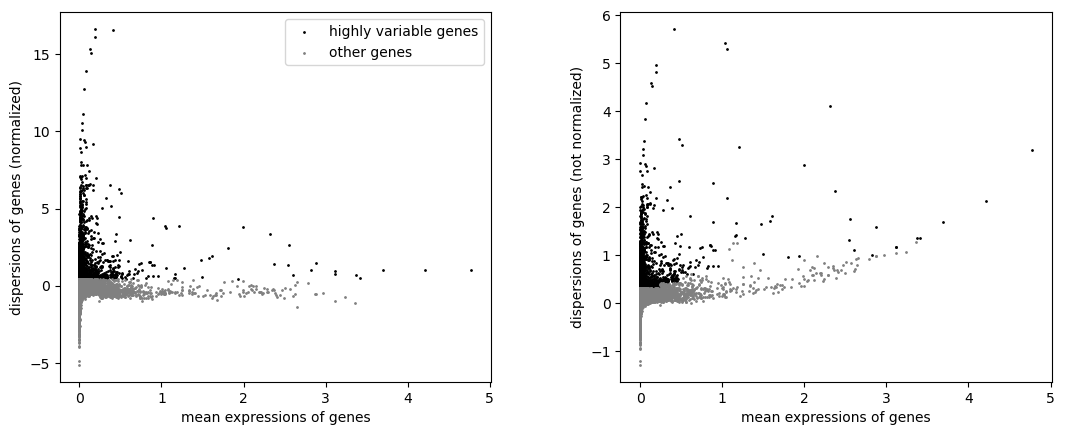

In [52]:
adata_208_D1 = adata[adata.obs['batch'] == f'SLN208-D1']
# now need to do normalization
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
# this CITE-seq data is mouse data
adata_208_D1.var["mt"] = adata.var_names.str.startswith("Mt-")
# ribosomal genes
adata_208_D1.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata_208_D1.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(adata_208_D1, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
# adata_qc.concatenate(adata_slice)

/var/folders/gt/1c8d4lks1vgbghz7rr9vnqzm0000gn/T/ipykernel_52535/1430448987.py:5: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_208_D1.var["mt"] = adata.var_names.str.startswith("Mt-")


In [53]:
adata_208_D2 = adata[adata.obs['batch'] == f'SLN208-D2']
# now need to do normalization
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
# this CITE-seq data is mouse data
adata_208_D2.var["mt"] = adata.var_names.str.startswith("Mt-")
# ribosomal genes
adata_208_D2.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata_208_D2.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(adata_208_D2, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
# adata_qc.concatenate(adata_slice)



/var/folders/gt/1c8d4lks1vgbghz7rr9vnqzm0000gn/T/ipykernel_52535/775478409.py:5: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_208_D2.var["mt"] = adata.var_names.str.startswith("Mt-")


In [47]:
adata_slice.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 6950238 stored elements and shape (6605, 13553)>

In [42]:
adata_slice

AnnData object with n_obs × n_vars = 6605 × 13553
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'isotypes_htos', 'protein_expression'